# Resolution Analysis - A repeat of the resolution analysis with the modified Ground Truth Data 

This spreadsheet explores the association process and develops a process for analyzing association accuracy as a function of lidar resolution. 

The data used for the analysis is taken from the Santa Clara Dataset.

The particular video and lidar data was captured on 09-18-2018 drive 0002

The object detector is the YoloV2 CNN detector
The association algorithm uses costs developed using 4 different costs components:

- The L2 norm (distance between the centroid of the bounding box and the ideal bounding box)
- The y2 estimate distance (the relative distance between the lidar distance and the estimated distance using y2)
- The inverse IOU ( 1 - the intersection over union of the bounding box and the ideal bounding box)
- The segment intersection (1 if the lidar intersects the object bounding box segments, 0 if not)

The association then makes assignments of LIDAR values to objects using the munres algorithm

Bad assignments are accepted or rejected using a max_cost threshold

Import libraries for python

In [1]:
import pandas as pd
import numpy as np
import cv2
from matplotlib import pyplot as plt

## Read in the data files for inspection

Define the paths to the ground truth data, the lidar data and the detection data. The files are shown below for reference but are accessed independently inside the RunAssociation class defined below.

In [2]:
# ground truth
gt_file = '../data/2018-09-18/viewer_logs/gt_records/gt_record_2018-09-18_0002.csv'
# lidar
lidar_file = '../data/2018-09-18/0002_filtered_new.csv'
# video detections
det_file = '../data/2018-09-18_drive_0002_detections_unfiltered.csv'
# images
video_dir = '../data/2018-09-18/2018-09-18_drive_0002_sync/image_02/data/'

Read the datafiles into pandas

In [3]:
gt_df = pd.read_csv(gt_file)
lidar_df = pd.read_csv(lidar_file, skiprows=2)
det_df = pd.read_csv(det_file)

### The LIDAR Data

Below is the raw LIDAR data for the run 0002 taken on 9-18-2018. Distances are in meters. Segments are 0 to 15 from left to right.

In [4]:
lidar_df.head()

,frame,unix_time,elapsed_time,fps,segment,distance,amplitude,flags,cluster_label
0,0,1537301999,0.079738,12.54,0,3.304718,67.488541,1,0
1,0,1537301999,0.079738,12.54,1,3.223022,144.673691,1,0
2,0,1537301999,0.079738,12.54,2,3.171188,156.708267,1,0
3,0,1537301999,0.079738,12.54,3,3.123764,190.157654,1,0
4,0,1537301999,0.079738,12.54,4,3.098648,215.041870,1,0


### The Detection Data

Below is the detection data precompiled and stored off-line by running a YOLOv3 CNN detector trained on the COCO object library. This data is unfiltered and includes all object detections. The detection_class is one of the 90+ object classes from COCO. The detection_confidence is a value between 0 and 1 from the YOLO detector. The values x1, y1, x2, y2 are the x and y values in pixels for points 1 and 2 that are the upper left corner and the lower right corner of detected object's bounding box in the image plane.  

In [5]:
det_df.head()

,Unnamed: 0,frame,detection_index,detection_class,detection_confidence,x1,y1,x2,y2
0,0,247,0,oven,0.867997,1097,462,1280,717
1,1,248,0,oven,0.844510,1099,461,1278,718
2,2,249,0,oven,0.705359,1107,471,1275,712
3,3,250,0,oven,0.818122,1076,457,1269,720
4,4,251,0,oven,0.947792,1063,430,1279,718


At this point, let's filter the detection data to include only objects in the detection classes of interest. Pandas' .loc method is used to select only the object types that are in the detection_classes list defined below.

In [6]:
detection_classes = ['car']

In [7]:
det_df = det_df.loc[det_df['detection_class'].isin(detection_classes)]

det_df.head()

,Unnamed: 0,frame,detection_index,detection_class,detection_confidence,x1,y1,x2,y2
61,61,369,0,car,0.729770,1175,471,1272,719
62,62,370,0,car,0.841500,1164,467,1271,720
63,63,371,0,car,0.766571,1152,466,1271,720
64,64,372,0,car,0.851768,1147,513,1272,720
65,65,373,0,car,0.923187,1138,511,1271,720


### The Ground Truth Data

Below is the ground truth (labeled) data showing the distances of objects that have been manually identified as correct by the user for the purposes of accuracy evaluation

In [8]:
gt_df.head()

,det_frame,lidar_frame,association_index,is_valid,is_manual,video_detection_index,lidar_detection_index,detection_class,detection_confidence,lidar_segment,lidar_distance,x1,y1,x2,y2
0,2532,2530,0,False,False,0,1,car,0.999985,14,126.797638,916,392,1277,566
1,2533,2531,0,False,False,0,2,car,0.999970,13,125.352058,911,392,1270,559
2,2534,2532,0,False,False,0,1,car,0.999839,15,118.627026,896,386,1257,554
3,2535,2533,0,False,False,0,1,car,0.999940,15,118.627026,894,382,1234,545
4,2536,2534,0,False,False,0,1,car,0.999939,15,118.627026,885,385,1213,540


### Looking under the hood at the Ground Truth Data

The first thing to note is that there are 2 frame numbers in the ground truth dataframe. These are:

- the det_frame - the frame number of the video detection object
- the lidar_frame - the frame number of the lidar distance value

The reason for these two different frame numbers is that the video typically lags the lidar data by about 2 frames due to the latency in the video pipeline. The lag_frames variable is set to 2 to compensate for the lag of the video frames. 

There are two boolean columns in the Ground Truth dataframe. These are:

- is_valid - labels whether the detection of interest has a valid ground truth value. If it does, we can use associations that are made on this object's detection_index to determine if the association of a lidar value is correct. Conversely, if the is_valid value is False, then no ground truth distance has been determined so it is excluded from the accuracy assessment.

- is_manual - labels whether the distance associated with an object was determined by a correct association with a lidar value during the labeling process (is_manual = False) or whether the lidar value was determined manually by the user (is_manual = True).

There are also several other columns that will be used to determine the accuracy. These are:

- video_detection_index - this is the index of the detected object that has been labeled with a distance values

- distance - this is the ground truth distance (in feet) of the object as labeled by the user.

Also included in the ground truth dataframe are several other columns that are duplicated from the video_detection dataframe during the process of labeling. These are:

- the video_detection_index
- the detection_class
- the detection_confidence
- the x and y values for the upper left and lower right corners of the detected object bounding box (x1, y1, x2, y2) 

In addtion, several values were duplicated from the lidar dataframe. These are:

- the lidar_detection_index
- the lidar_segment
- the lidar_distance

Also included is the association index which is saved if the association value was used to label the ground truth. If a manual selection of a different association was made or if the distance was entered manually by the user the association_index is set to -1. 

Also note that if a manual value is entered for the distance by the user, the lidar_index and lidar_segment values are also set to -1. 

### Determining the number of valid ground truth values that can be used for assessment of association accuracy

Let's determing the number of valid object distances from the ground truth data. These have values in the 'is_valid' column that are True. These frames will be used later to determine the accuracy of the association algorithm and its accuracy as a function of the LIDAR resolution 

In [9]:
valid_gt_frames = gt_df.loc[gt_df['is_valid']]['det_frame'].unique()

In [10]:
print('The number of valid, labeled ground truth objects in the dataset is {}'.format(len(valid_gt_frames)))

The number of valid, labeled ground truth objects in the dataset is 975


## Setting up to evaluate Association Accuracy

To evaluate association accuracy we must first set the Jupyter Notebook up to access the viewer directory and use these algorithms to simplify the process.

Update the path to access the viewer algorithms

In [11]:
!ls ../viewer/src/association/

association_old.py  association_test.py  __init__.py  __pycache__
association.py	    costs.py		 munkres.py


In [12]:
import sys
import os

new_path = "../viewer/src/"

if new_path not in sys.path:
    sys.path.append(new_path) # go to parent dir
    sys.path.append("../viewer/src/association") # go to parent dir
sys.path.append(os.getcwd()+"/venv/lib/python3.6/site-packages") # go to parent dir

print(sys.path)


['/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '', '/home/robert/.local/lib/python3.6/site-packages', '/usr/local/lib/python3.6/dist-packages', '/usr/local/lib/python3.6/dist-packages/pointnet2-0.0.0-py3.6-linux-x86_64.egg', '/usr/local/lib/python3.6/dist-packages/iou3d-0.0.0-py3.6-linux-x86_64.egg', '/usr/local/lib/python3.6/dist-packages/roipool3d-0.0.0-py3.6-linux-x86_64.egg', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/home/robert/.ipython', '../viewer/src/', '../viewer/src/association', '/mnt/second_drive/PycharmProjects/resolution_analysis/venv/lib/python3.6/site-packages']


Now that we have access to the viewer directories, let's import some of the utilities

In [13]:
import util.calibration as cal_santaclara
import util.calibration_kitti as cal_kitti
import util.util as util
import util.drawing_util as drawing_util

## Creating a custom class to access the viewer methods and data structures

### The RunAssociations Class

The RunAssociations Class is built to create a enviroment that we can run associations using the same code and algorithms that are written in the viewer application without the viewer GUI. Most of the code for this class is copied directly from the viewer.py file.

In [14]:
# the class that instantiates methods needed to run associations
class RunAssociations():
    def __init__(self):
        self.run_date_idx = 1
        self.run_number_idx = 0

        self.data_dir = '../data/'
        self.run_dates = ['2011_09_26', '2018-09-18', '2018-09-20', '2018-12-17']
        self.run_numbers = {
            '2011_09_26':['0001','0002','0005','0009','0015'],
            '2018-09-18': ['0002', '0003'],
            '2018-09-20': ['0002'],
            '2018-12-17': ['0002', '0003']
        }
        self.run_types = {
            '2011_09_26':'kitti',
            '2018-09-18':'santaclara',
            '2018-09-20':'santaclara',
            '2018-12-17':'santaclara'
        }
        self.run_date = self.run_dates[self.run_date_idx]
        self.run_number = self.run_numbers[self.run_dates[self.run_date_idx]][self.run_number_idx]
        self.run_type = self.run_types[self.run_dates[self.run_date_idx]]

        # n_segs controls the number of lidar segments displayed and used for calculation of associations
        self.n_segs_idx = 0
        self.n_segs_choices = [16,8,4,2,1]
        self.n_segs = self.n_segs_choices[self.n_segs_idx]
        self.seg_step = 16 // self.n_segs

        # turns on and off the mouse click pixel coordinates on the screen
        self.show_coord = False
        self.mouse_x = 0
        self.mouse_y = 0

        # variable holds the last right click distance projected to the ground
        self.click_dist = 0
        
        self.lag_frames_idx = 2
        self.lag_frames_choices = [0,1,2,3,4]
        self.lag_frames = self.lag_frames_choices[self.lag_frames_idx]

        # these values are not currently updated by the app
        self.frame_total_possible = 0
        self.frame_true_positives = 0
        self.frame_false_positives = 0
        self.frame_false_negatives = 0
        self.run_total = 0
        self.run_true_positives = 0
        self.run_false_positives = 0
        self.run_false_negatives = 0
        self.percent_true_positives = 0
        self.percent_false_positives = 0
        self.percent_false_negatives = 0

        # min and max distances for lidar values and ground_truth objects (kitti)
        self.min_distance = 10
        self.max_distance = 200

        # create lists of current video objects
        self.df_list = []
        self.colors_list = []
        self.types_list = []

        # data frame objects to hold different data generated by AssociationTest class
        self.at = None
        self.gt_frame = None
        self.det_frame = None
        self.lidar_frame = None
        self.tracklet_df = None
        self.clustered_df_frame = None # all of the visible kitti points for the current frame
        self.clustered_segs_only = None  # just the kitti points in the lidar regions
        self.association_frame = None
        self.assignments_frame = None
        self.total_cost_frame = None
        self.l2_norm_cost_frame = None
        self.y2_est_cost_frame = None
        self.iou_cost_frame = None
        self.gt_record_df = None

        # initial weights and max_cost for the association processes
        self.l2_norm_weight = 0.34
        self.y2_est_weight = 0.33
        self.iou_weight = 0.33
        self.seg_intersect_weight = 0
        self.max_cost = 0.5
        self.enable_max_cost = True
        self.use_intersecting_only = True
        self.min_det_confidence = 0.85
        self.enable_min_det_confidence = True
        self.use_filtered_data = True
        self.use_detector = True
        self.enable_record_gt = False
        self.gt_record_columns = ['det_frame', 'lidar_frame', 'association_index', 'is_valid',
                                  'is_manual', 'video_detection_index', 'lidar_detection_index',
                                  'detection_class', 'detection_confidence',
                                  'lidar_segment', 'lidar_distance', 'x1', 'y1', 'x2', 'y2']

        self.weights = [self.l2_norm_weight, self.y2_est_weight, self.iou_weight, self.seg_intersect_weight]
        self.gt_object_classes = ['Car', 'Truck', 'Van']
        # self.det_object_classes = ['car', 'truck', 'bus']
        self.det_object_classes = ['car']

        # set all of the is_old dictionary values to True so that everything gets updated during the first init
        self.isOld = {
            'gt_frame'          : True,
            'det_frame'         : True,
            'lidar_frame'       : True,
            'association'       : True,
            'accuracy'          : True,
            'accuracy_settings' : True,
            'filtered'          : True,
            'image'             : True,
            'dataset'           : True,
            'clusters'          : True,
            'ground_truth'      : True
        }

        # create class level image variables
        self.image = None
        self.display_image = None
        self.bmp = None
        self.image_rows = None
        self.image_cols = None

        self.association_settings_keys = ['run_date', 'run_number', 'run_type', 'n_segs', 'lidar_left', 'lidar_right',
                          'lidar_top', 'lidar_bottom', 'min_valid_frame', 'max_valid_frame',
                          'n_valid_frames', 'lag_frames', 'l2_norm_weight', 'y2_est_weight',
                          'iou_weight', 'seg_intersect_weight', 'max_cost', 'enable_max_cost',
                          'use_intersecting_only', 'det_object_classes', 'run_start_frame',
                          'run_stop_frame', 'use_detector', 'min_det_confidence',
                          'enable_min_det_confidence', 'use_filtered_data']

        
        # load the dataset for the first time
        util.load_dataset(self)

        # initialize the show variables for the display image
        self.show_index_numbers = False
        self.show_kitti_points = False
        self.show_all_kitti_points = False
        self.show_detection_zones = True
        self.show_video_detections = True
        self.show_lidar_detections = False
        self.show_ground_truth = False
        self.show_associations = True
        self.show_3d_ground_truth = False
        self.show_lidar_values = True
        self.detection_zone_color = (255, 0, 0, 255)
        self.video_detections_color = (0, 0, 255, 255)
        self.lidar_detections_color = (255, 0, 0, 255)
        self.ground_truth_color = (0,255, 0, 255)
        self.associations_color = (0, 255, 255, 255)
        self.threeD_ground_truth_color = (255, 127, 0, 255)
        self.lidar_value_color = (255, 0, 0, 255)
        
        # initialize the calibration and the boundaries of the lidar region
        self.cal = util.update_cal(self)
        self.lidar_left = self.cal.SEG_TO_PIXEL_LEFT[0]
        self.lidar_right = self.cal.SEG_TO_PIXEL_RIGHT[15]
        self.lidar_top = self.cal.SEG_TO_PIXEL_TOP
        self.lidar_bottom = self.cal.SEG_TO_PIXEL_BOTTOM

#         self.valid_frames = self.at.get_valid_frames()
#         self.min_valid_frame = min(self.valid_frames)
#         self.max_valid_frame = max(self.valid_frames)
#         self.n_valid_frames = len(self.valid_frames)
        
                    
    def get_frame(self):

        # fetch the latest frame from AssociationTest
        self.image, self.gt_frame, self.det_frame, self.lidar_frame, self.association_frame = self.at.get_frame(2, self.current_frame, self.use_filtered_data, self.use_detector, self.weights, self.isOld, self.run_types[self.run_date])
        util.set_is_old('except_list_true', ['dataset'])
        return

    def update_display_image(self):

        # start the process of updating the display image by making a deep copy and based on the users preferences
        # for what to display, add information to the display_image
        self.display_image = self.image.copy()
        drawing_util.update_displayed_object_lists(self)

        self.display_image = drawing_util.draw_bboxes(self, self.display_image, self.df_list, self.colors_list, self.types_list)

        if self.show_detection_zones:
            self.display_image = drawing_util.draw_detzone(self, self.display_image, self.detection_zone_color[0:3])

        if self.show_3d_ground_truth:
            self.display_image = drawing_util.draw_3d_bboxes(self, self.display_image, [self.gt_frame], [self.threeD_ground_truth_color[0:3]], ['3d_ground_truth'])

        if self.show_kitti_points:
            self.display_image = drawing_util.draw_kitti_points(self, self.display_image)

        if self.show_lidar_values:
            self.display_image = drawing_util.draw_lidar_values(self, self.display_image, self.lidar_value_color, text_size = 1, text_weight = 2)

        if self.show_coord:
            cv2.putText(self.display_image,'x: {0:0.0f}, y: {1:0.0f}'.format(self.mouse_x,self.mouse_y),(25,25),1,1.5,(255,0,0),2)
            cv2.putText(self.display_image,'click_dist: {0:0.2f}'.format(self.click_dist),(25,50),1,1.5,(255,0,0),2)
        else:
            self.mouse_x = 0
            self.mouse_y = 0
        if self.enable_record_gt:
            cv2.putText(self.display_image, self.right_click_messages[self.right_click_idx],(25,700),1,1,(255,0,0),2)


### Make an instance of the RunAssociations Class

In [15]:
ra = RunAssociations()
#print(dir(ra.at))
type(ra.at)


association.association_test.AssociationTest

### Using the Run Associations Class

The first method of the RunAssociations Class that is examined is the get_frame method.

The get_frame method 

#### Get a frame of data

In [16]:
ra.current_frame = 2546
ra.at.parent_data.run_start_frame = 10
ra.isOld['image'] = True
ra.get_frame()

### The image attribute of the RunAssociations Class

One of the important attributes in the RunAssociatons Class is the 'image' atttribute. Let's take a look the image for the current frame below.  

ra.image is a numpy array containing the pixel values for the raw image for the current_frame.


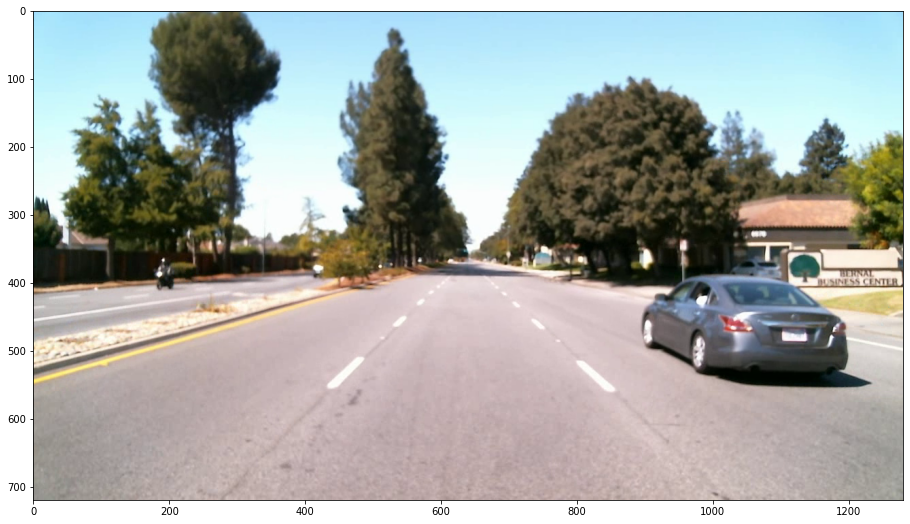

In [17]:
fig1, ax1 = plt.subplots(figsize=(16, 9)) # make a figure
ax1.imshow(ra.image) # show the image attribute

### The display_image attribute of the RunAssociations Class

The display_image attribute is built on top of the image attribute and is overlaid with various information about the current frame. This includes ground truth bounding boxes, video detection bounding boxes, association information, lidar detection data, index numbers and the location of the lidar detection zones.

These attributes may be turn on and off by setting the show... variables for the various overlays. Setting a show variable True, turns in on, and setting a show variable False turns it off.

#### The show variables and their default settings

- show_index_numbers = False
- show_kitti_points = False
- show_all_kitti_points = False
- show_detection_zones = True
- show_video_detections = True
- show_lidar_detections = False
- show_ground_truth = False
- show_associations = True
- show_3d_ground_truth = False
- show_lidar_values = True

#### The default colors of the overlays (R, G, B, Alpha)

- detection_zone_color = (255, 0, 0, 255) # Red
- video_detections_color = (0, 0, 255, 255) # Blue
- lidar_detections_color = (255, 0, 0, 255) # Red
- ground_truth_color = (0,255, 0, 255) # Green
- associations_color = (0, 255, 255, 255) # Cyan
- threeD_ground_truth_color = (255, 127, 0, 255) # Orange
- lidar_value_color = (255, 0, 0, 255) # Red


### Showing a frame with a custom overlay

Let's access one of the frames of video that has a ground truth value assigned and display the ground_truth bounding box, the lidar detection zone with everything else turned off.

First let's list the first 10 frames that have valid ground truth data

In [18]:
valid_gt_frames[:10]

array([2540, 2541, 2545, 2546, 2547, 2548, 2549, 2550, 2551, 2552])

### Modifying the default display_image

Now let's set the current frame to the second value in the list: frame 2540 and set the Ground Truth overlay, the Detection Zones overlay and the LIDAR Values overlay to True and everything else to False. Since most of the values are already set by default, we only need to turn on the Ground Truth overlay and turn off the Video Detections overlay and the Associations overlay by setting these values to false

In [19]:
ra.show_ground_truth = True
ra.show_video_detections = False
ra.show_associations = False

### Getting the new frame and updating the image

- set the current frame to 2540 
- get the frame
- update the display image
- make a plot
- show the display_image attribute

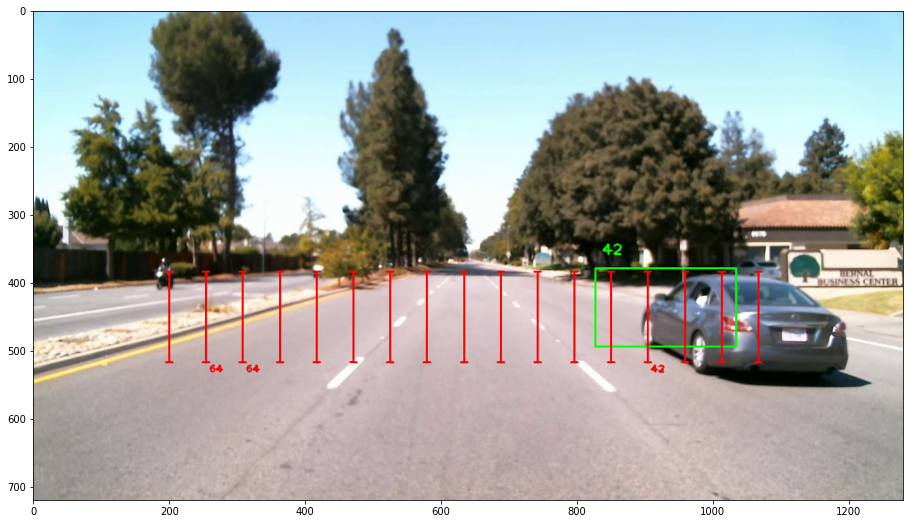

In [20]:
ra.lag_frames_idx = 2
ra.current_frame = 2546
ra.isOld['image'] = True
ra.isOld['det_frame'] = True
ra.isOld['lidar_frame'] = True
ra.isOld['gt_frame'] = True


ra.get_frame()
ra.update_display_image()
fig2, ax2 = plt.subplots(figsize=(16, 9))
ax2.imshow(ra.display_image)


### Accessing the raw dataframes in the RunAssociations class

The files that we access manually are accessed as part of the RunAssociations class

They are located in a sub-class called 'at' which is an instance of the AssociationTest Class

The Ground Truth dataframe is at 

- ra.at.gt_df

The Video Detections dataframe is at

- ra.at.det_df

The Lidar Detections dataframe is at

- ra.at.lidar_df

### Accessing the current frame's dataframes

The current frame's Ground Truth is at

- ra.gt_frame

The current frame's Video detection is at

- ra.det_frame

The current frame's Lidar detections is at

- ra.lidar_frame

### Accessing the associations information for the current frame

The association results for the current frame given the settings for weights and max_cost are at

- ra.association_frame



For example, here is the ground truth dataframe for the entire run:

In [21]:
ra.at.gt_df.head()

,det_frame,lidar_frame,association_index,is_valid,is_manual,video_detection_index,lidar_detection_index,detection_class,detection_confidence,lidar_segment,lidar_distance,x1,y1,x2,y2
8,2540,2538,0,True,False,0,2,car,0.999839,15,35.527548,865,389,1127,516
9,2541,2539,0,True,False,0,0,car,0.999762,14,37.354999,853,391,1131,517
13,2545,2543,0,True,False,0,2,car,0.999446,14,42.055086,825,381,1057,498
14,2546,2544,0,True,False,0,2,car,0.999818,13,41.827156,827,379,1034,494
15,2547,2545,0,True,False,0,2,car,0.999810,13,43.166655,830,379,1025,488


Here is the ground_truth data for the current frame

In [22]:
ra.gt_frame.head()

,det_frame,lidar_frame,association_index,is_valid,is_manual,video_detection_index,lidar_detection_index,detection_class,detection_confidence,lidar_segment,lidar_distance,x1,y1,x2,y2
14,2546,2544,0,True,False,0,2,car,0.999818,13,41.827156,827,379,1034,494


If we switch the current frame and execute get_frame the information in gt_frame is updated

In [23]:
ra.current_frame = 2541
ra.get_frame()
ra.gt_frame.head()

,det_frame,lidar_frame,association_index,is_valid,is_manual,video_detection_index,lidar_detection_index,detection_class,detection_confidence,lidar_segment,lidar_distance,x1,y1,x2,y2
9,2541,2539,0,True,False,0,0,car,0.999762,14,37.354999,853,391,1131,517


If we want to look at the associations for the current frame they are contained in the association_frame dictionary

In [24]:
print(ra.association_frame)

{'assignments': [], 'total_costs': [], 'cost_components': [], 'function_names': None}


The association_frame dictionary contains 4 keys. They are:

- 'assignments' - this is a list of tuples containing the indicies of the video detection object and the lidar detection as an ordered pair for each of the associations made for the current frame

- 'total_costs' - a numpy array with containing the sum of the weighted costs for each potential association between detected objects and detected lidar values. The shape of the array is n x m where n is the number of objects detected and m is the number of lidar values detected.

- 'cost_components' - 4 element list containing each of the cost components as an n x m array as defined above.

- 'function_names' - Not returned.

In [25]:
total, tp, fp, fn, stats, details = ra.at.evaluate_run_association_accuracy(2,True,True,(.5,.4,.1),"kitti")


ZeroDivisionError: division by zero

In [ ]:
print('n_segs: {0:0.0f}, max_cost: {1:0.4f}, weights: [L2: {2:0.4f}, y2: {3:0.4f}, iou: {4:0.4f}, segint: {5:0.4f}]'.format(ra.n_segs, ra.max_cost, ra.weights[0], ra.weights[1], ra.weights[2], ra.weights[3]))
print('total: {0:0.0f}, tp: {1:0.0f}, fp: {2:0.0f}, fn: {3:0.0f}'.format(total, tp, fp, fn))
print('Accuracy: {0:0.4f}, Precision: {1:0.04f}, Recall: {2:0.4f}'.format(stats[0], stats[1], stats[2]))

In [ ]:
len(ra.at.gt_df_filtered.loc[ra.at.gt_df_filtered['is_valid']==True])

In [ ]:
for i in range(len(ra.n_segs_choices)):
    ra.n_segs_idx = i
    ra.n_segs = ra.n_segs_choices[i]
    ra.seg_step = 16 // ra.n_segs
    util.set_is_old(ra.isOld, 'list_true',
                   list=['image', 'gt_frame', 'det_frame', 'lidar_frame', 'association', 'clusters', 'accuracy_settings'])
    total, tp, fp, fn, stats, details = ra.at.evaluate_run_association_accuracy(2,True,True,(.5,.4,.1),"kitti")
    #total, tp, fp, fn, stats, details = ra.at.evaluate_run_association_accuracy()
    print('-'*64)
    print('n_segs: {0:0.0f}, max_cost: {1:0.4f}, weights: [L2: {2:0.4f}, y2: {3:0.4f}, iou: {4:0.4f}, segint: {5:0.4f}]'.format(ra.n_segs, ra.max_cost, ra.weights[0], ra.weights[1], ra.weights[2], ra.weights[3]))
    print('total: {0:0.0f}, tp: {1:0.0f}, fp: {2:0.0f}, fn: {3:0.0f}'.format(total, tp, fp, fn))
    print('Accuracy: {0:0.4f}, Precision: {1:0.04f}, Recall: {2:0.4f}'.format(stats[0], stats[1], stats[2]))


In [ ]:
len(ra.at.gt_df_filtered)

In [ ]:
details


In [ ]:
import random
import time

currenttime = time.time()

seed = int((currenttime * 100  - int (currenttime * 100)) * 1000)

print(seed)

seed = 776

random.seed(seed)

def random_parameters_generator():
    
    r0 = random.randint(0,100)
    r1 = random.randint(0,100)
    r2 = random.randint(0,100)
    rlist = [0, r0, r1, r2, 100]
    rlist.sort()

    r0 = rlist[1] - rlist[0]
    r1 = rlist[2] - rlist[1]
    r2 = rlist[3] - rlist[2]
    r3 = rlist[4] - rlist[3]
    r4 = random.randint(30,100)
    
    return [r0/100, r1/100, r2/100, r3/100, r4/100]

In [ ]:
n = 200
for j in range(n):
    w = random_parameters_generator()
    ra.l2_norm_weight = w[0]
    ra.y2_est_weight = w[1]
    ra.iou_weight = w[2]
    ra.seg_intersect_weight = w[3]
    ra.max_cost = w[4]
    ra.weights = [w[0], w[1], w[2], w[3]]
    for i in range(len(ra.n_segs_choices)):
        ra.n_segs_idx = i
        ra.n_segs = ra.n_segs_choices[i]
        ra.seg_step = 16 // ra.n_segs
        util.set_is_old(ra.isOld, 'list_true',
                       list=['image', 'gt_frame', 'det_frame', 'lidar_frame', 'association', 'clusters', 'accuracy_settings'])
        total, tp, fp, fn, stats, details = ra.at.evaluate_run_association_accuracy()
        print('-'*64)
        print('RUN {} of {}'.format(j*5+i, n*5))
        print('n_segs: {0:0.0f}, max_cost: {1:0.4f}, weights: [L2: {2:0.4f}, y2: {3:0.4f}, iou: {4:0.4f}, segint: {5:0.4f}]'.format(ra.n_segs, ra.max_cost, ra.weights[0], ra.weights[1], ra.weights[2], ra.weights[3]))
        print('total: {0:0.0f}, tp: {1:0.0f}, fp: {2:0.0f}, fn: {3:0.0f}'.format(total, tp, fp, fn))
        print('Accuracy: {0:0.4f}, Precision: {1:0.04f}, Recall: {2:0.4f}'.format(stats[0], stats[1], stats[2]))
